In [1]:
from sympy import *
from sympy.physics.mechanics import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches

In [92]:
t = symbols('t')
x, y, theta = dynamicsymbols('x, y, theta')
omega, u, v = dynamicsymbols('omega, u, v')
omega_0, delta_omega, u_0, delta_u = dynamicsymbols('omega_0, delta_omega, u_0, delta_u')
w_omega, w_u, w_v = dynamicsymbols('w_omega, w_u, w_v')
init_vprinting()

eta = Matrix([
    [cos(theta), -sin(theta), x],
    [sin(theta), cos(theta), y],
    [0, 0, 1]
])

omega = omega_0 + delta_omega
u = u_0 + delta_u

v_0 = Matrix([
    [0, -omega_0, u_0],
    [omega_0, 0, 0],
    [0, 0, 0]
])

dv = Matrix([
    [0, -delta_omega, delta_u],
    [delta_omega, 0, 0],
    [0, 0, 0]
])

# noise
w = Matrix([
    [0, -w_omega, w_u],
    [w_omega, 0, 0],
    [0, 0, 0]
])

v = v_0 + dv + w

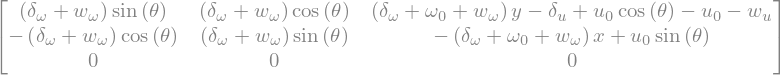

In [93]:
res = eta@v_0 - v@eta
res.simplify()
res

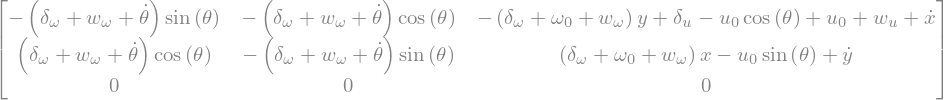

In [94]:
eq = eta.diff(t) - res
eq.simplify()
eq

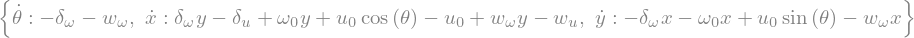

In [95]:
x_vect = Matrix([x, y, theta])
sol = solve(eq, [xi.diff(t).simplify() for xi in x_vect])
sol

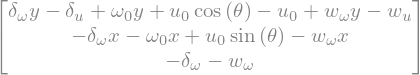

In [96]:
x_vect = Matrix([x, y, theta])
f_vect = Matrix([sol[k] for k in [xi.diff(t) for xi in x_vect]])
f_vect

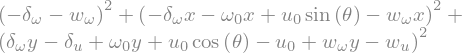

In [97]:
V = (f_vect.T*f_vect)[0]
V.simplify()
V

In [98]:
Matrix([V]).jacobian(x_vect)

In [99]:
x0 = Matrix([0, 0, 0])
u0 = Matrix([0, 0])

A = f_vect.jacobian(x_vect)

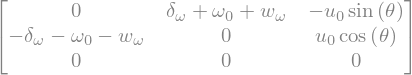

In [100]:
A

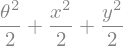

In [101]:
V_lyap = (x**2 + y**2 + theta**2)/2
V_lyap

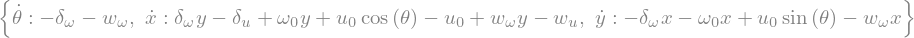

In [102]:
sol_stab = dict(sol)
#sol_stab[theta.diff(t)] = -theta
#sol_stab[x.diff(t)] += -x
#sol_stab[y.diff(t)] += -y
sol_stab

In [103]:
V_dot = V_lyap.diff(t).subs(sol_stab).simplify().collect(u_0*x)
V_dot

In [104]:
controls = {
    delta_u: x + u_0*(cos(theta) - 1),
    delta_omega: theta + u_0*y*sin(theta)/theta
}

V_dot.subs(controls).simplify()

$\dot{V} < 0$ when $V > ?$

$\theta^2 + x^2 > \theta  |w_\omega| + |w_u| x$

If $|\theta| >  |w_\omega|$ then $\theta^2 > |w_\omega|\theta$

If $|x| >  |w_u|$ then $x^2 > |w_u|x$


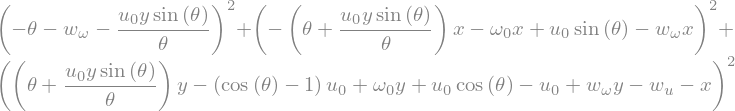

In [105]:
V.subs(controls)

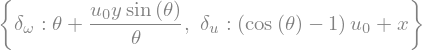

In [106]:
controls

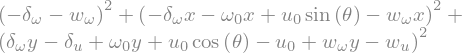

In [107]:
V

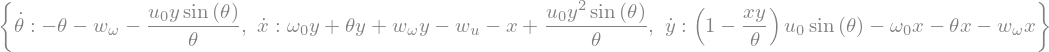

In [108]:
sol_stab_sub = {key: sol_stab[key].subs(controls).simplify().collect(u_0*sin(theta)) for key in sol_stab}
sol_stab_sub

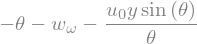

In [109]:
sol_stab_sub[theta.diff(t)]

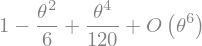

In [110]:
(sin(symbols('theta'))/symbols('theta')).series(symbols('theta'), n=6)

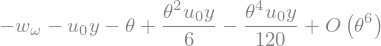

In [111]:
sol_stab_sub[theta.diff(t)].subs(theta, symbols('theta')).series(symbols('theta'), n=6)

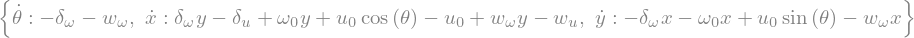

In [112]:
sol_stab

1.0493480220054467


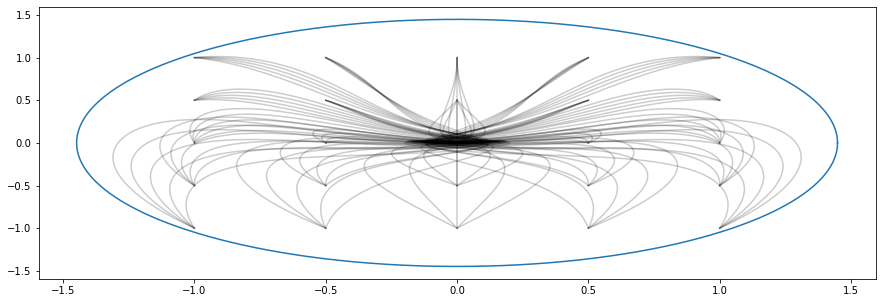

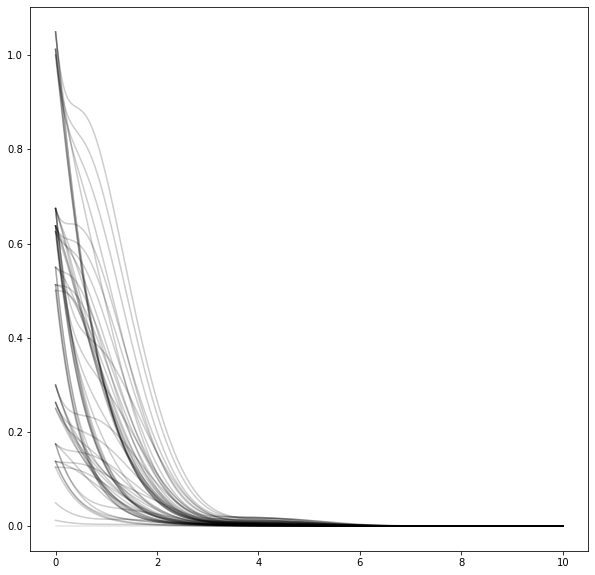

In [113]:
import scipy.integrate

theta_max = np.pi/10
# x_vect = []

def f(t, x_vect):
    omega_0 = 0
    u_0 = 1
    theta, x, y = x_vect
    if np.abs(theta) < 1e-2:
        sin_theta_over_theta = 1 - theta**2/6 + theta**4/120
    else:
        sin_theta_over_theta = np.sin(theta)/theta
    
    delta_omega = theta + u_0*y*sin_theta_over_theta + 0*np.sin(2*np.pi*t)
    delta_u = (np.cos(theta) - 1)*u_0 + x + 0*np.sin(2*np.pi*t)
    x_dot = [
        -delta_omega,
        delta_omega*y - delta_u + omega_0*y + u_0*(np.cos(theta)-1),
        -delta_omega*x - omega_0*x + u_0*np.sin(theta)
    ]
    return x_dot

def plot_sim(res):
    plt.figure(1)
    theta = res['y'][0, :]
    x = res['y'][1, :]
    y = res['y'][2, :]
    plt.plot(res['t'], theta, 'k')
    plt.show()

    plt.figure(2)
    plt.plot(x, y)
    plt.show()
    
def plot_stab():
    plt.figure(1, figsize=(10, 10))
    f1 = plt.gca()
    plt.figure(2, figsize=(10, 10))
    f2 = plt.gca()
    #plt.figure(3, figsize=(10, 10))
    #f3 = plt.gca()
    
    for theta0 in np.linspace(-theta_max, theta_max, 5):
        for x0 in np.linspace(-1, 1, 5):
            for y0 in np.linspace(-1, 1, 5):
                t = np.linspace(0, 10, 1000)
                res = scipy.integrate.solve_ivp(f, [t[0], t[-1]], t_eval=t, y0=[theta0, x0, y0])
                theta = res['y'][0, :]
                x = res['y'][1, :]
                y = res['y'][2, :]
                V = (theta**2 + x**2 + y**2)/2
                f1.plot(y, x, color='k', alpha=0.2)
                f2.plot(t, V, color='k', alpha=0.1)
                #f3.plot(t, theta)

    V_max = (1**2 + 1**2 + theta_max**2)/2
    print(V_max)
    theta_circ = np.linspace(0, 2*np.pi, 1000)
    r_circ = np.sqrt(2*V_max)
    f1.plot(r_circ*np.cos(theta_circ), r_circ*np.sin(theta_circ))

plt.figure(figsize=(15, 5))    
plot_stab()

* Efficient Construction of Polyhedral Invariant Hybrid Automaton for Model Checking of UAM Traffic Patterns
* Scitech: June 1 (Extended Abstract): Most appropriate conference
* Paper
  * Compare HJB, Lyapunov, LMI for the Dubin's Car, Invariant Set Construction
  * Ignore estimation error for now
* Melody
  * Check lyapunov
  * Write abstract
* Emma
  * Wrap up git
  * Look at simulator if you have time